In [71]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings(action='ignore')

df_org = pd.read_csv('/content/drive/MyDrive/high_diamond_ranked_10min.csv')

df_org

plt.rcParams['figure.dpi'] = 144

df_org

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled
0,4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55
1,4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52
2,4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28
3,4524384067,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,15,2,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47
4,4436033771,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,17,2,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,4527873286,1,17,2,1,7,4,5,1,1,0,0,17765,7.2,18967,211,69,46,3,0,4,7,7,0,0,0,0,15246,6.8,16498,229,34
9875,4527797466,1,54,0,0,6,4,8,1,1,0,0,16238,7.2,19255,233,48,12,21,1,4,6,3,0,0,0,0,15456,7.0,18367,206,56
9876,4527713716,0,23,1,0,6,7,5,0,0,0,0,15903,7.0,18032,210,45,14,0,1,7,6,11,1,1,0,0,18319,7.4,19909,261,60
9877,4527628313,0,14,4,1,2,3,3,1,1,0,0,14459,6.6,17229,224,48,66,4,0,3,2,1,0,0,0,0,15298,7.2,18314,247,40


In [5]:
df_org.info() ## 결측치 없음
df_org[df_org.duplicated()] ## 중복값 없음.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled


In [6]:
target = 'blueWins'  # 블루팀이 승리하였는지 여부

df_org[target].value_counts() # target은 balanced한 데이터.

0    4949
1    4930
Name: blueWins, dtype: int64

In [7]:
df_org['blueWardsPlaced'].describe()  # 와드 설치량이 비정상적으로 많게 나오는 이상치 존재

count    9879.000000
mean       22.288288
std        18.019177
min         5.000000
25%        14.000000
50%        16.000000
75%        20.000000
max       250.000000
Name: blueWardsPlaced, dtype: float64

In [8]:
def feature_engineering(df):
  df = df.drop_duplicates()
  df = df.dropna()

  # 이상치 제거
  blue_strange = df[df['blueWardsPlaced'] > 30].index
  for idx in blue_strange:
    df['blueWardsPlaced'][idx] = 15

  red_strange = df[df['redWardsPlaced'] > 30].index
  for idx in red_strange:
    df['redWardsPlaced'][idx] = 15

  blue_strange_des = df[df['blueWardsDestroyed'] > 10].index
  for idx in blue_strange_des:
    df['blueWardsDestroyed'][idx] = 15

  red_strange_des = df[df['redWardsDestroyed'] > 10].index
  for idx in red_strange_des:
    df['redWardsDestroyed'][idx] = 15

  # 킬, 데스, 어시스트 정보로 KDA 정보 만들기
  df['blueKDA'] = [0] * len(df)
  df['redKDA'] = [0] * len(df)

  for idx in df.index:
    if df['blueDeaths'][idx] == 0:
      df['blueKDA'][idx] = df['blueKills'][idx] + df['blueAssists'][idx]
    else:
      df['blueKDA'][idx] = (df['blueKills'][idx] + df['blueAssists'][idx]) / df['blueDeaths'][idx]
    
  for idx in df.index:
    if df['redDeaths'][idx] == 0:
      df['redKDA'][idx] = df['redKills'][idx] + df['redAssists'][idx]
    else:
      df['redKDA'][idx] = (df['redKills'][idx] + df['redAssists'][idx]) / df['redDeaths'][idx]

  df['KDADiffbyBlue'] = df['blueKDA'] - df['redKDA']

  # 정글몬스터와 미니언 처치수를 합하여 CS 정보 만들기
  df['CSDiffbyBlue'] = (df['blueTotalMinionsKilled'] + df['blueTotalJungleMinionsKilled']) - (df['redTotalMinionsKilled'] + df['redTotalJungleMinionsKilled']) 

  # 전체 골드량과 경험치량을 이용하여 골드차이, 레벨차이 정보 만들기
  df['GoldDiffbyBlue'] = df['blueTotalGold'] - df['redTotalGold']
  df['AvgLevDiffbyBlue'] = df['blueAvgLevel'] - df['redAvgLevel']

  # 와드설치, 와드파괴를 합하여 시야점수 정보 만들기
  df['blueVisionScore'] = df['blueWardsPlaced'] + df['blueWardsDestroyed']
  df['redVisionScore'] = df['redWardsPlaced'] + df['redWardsDestroyed']

  # 사용하지 않는 정보 제거
  df = df.drop(['blueKills', 'blueDeaths', 'blueAssists', 'redKills', 'redDeaths', 'redAssists',
                'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled',
                'redTotalMinionsKilled', 'redTotalJungleMinionsKilled',
                'blueTotalGold', 'redTotalGold', 'blueAvgLevel', 'redAvgLevel',
                'blueWardsPlaced', 'blueWardsDestroyed', 'redWardsPlaced', 'redWardsDestroyed',
                'blueEliteMonsters', 'redEliteMonsters',
                'gameId', 'redFirstBlood',
                'blueTotalExperience', 'redTotalExperience',
                'blueKDA', 'redKDA'], axis=1)
  
  return df

In [9]:
df = feature_engineering(df_org)

df.describe()

,blueWins,blueFirstBlood,blueDragons,blueHeralds,blueTowersDestroyed,redDragons,redHeralds,redTowersDestroyed,KDADiffbyBlue,CSDiffbyBlue,GoldDiffbyBlue,AvgLevDiffbyBlue,blueVisionScore,redVisionScore
count,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,0.499038,0.504808,0.361980,0.187974,0.051422,0.413098,0.160036,0.043021,-0.004251,-1.453082,14.414111,-0.009313,18.806256,18.654722
std,0.500024,0.500002,0.480597,0.390712,0.244369,0.492415,0.366658,0.216900,5.293242,34.935691,2453.349179,0.478434,3.876839,3.843455
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-35.000000,-173.000000,-10830.000000,-2.600000,5.000000,6.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,-25.000000,-1585.500000,-0.400000,16.000000,16.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,14.000000,0.000000,18.000000,18.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,21.000000,1596.000000,0.200000,21.000000,20.000000
max,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,2.000000,40.000000,152.000000,11467.000000,2.400000,45.000000,44.000000


In [10]:
# Blue 팀의 골드가 더 많을수록 승리 확률이 높아진다.
# Blue 팀의 CS가 더 많을수록 승리 확률이 높아진다.
# Blue 팀이 FirstBlood를 획득할 경우 승리 확률이 높아진다.
# Blue 팀의 KDA가 Red 팀의 KDA 보다 높을경우 승리 확률이 높아진다.

In [11]:
# Train, Test 세트 분리

from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=10)

X_train = train.drop(target, axis=1)
y_train = train[target]

X_test = test.drop(target, axis=1)
y_test = test[target]

# Hold-Out Validation 사용

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=10)

In [12]:
from sklearn.metrics import accuracy_score

major_pred = y_train.mode()
train_pred = [major_pred] * len(y_train)  # base-model training
major_val = y_val.mode()
val_pred = [major_val] * len(y_val)  # base-model validation

print('기본 모델의 훈련정확도 : %.3f' % accuracy_score(y_train, train_pred))
print('기본 모델의 검증정확도 : %.3f' % accuracy_score(y_val, val_pred))

기본 모델의 훈련정확도 : 0.501
기본 모델의 검증정확도 : 0.500


In [13]:
# LogisticRegression을 사용하여 모델 학습

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

pipe_log = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=10)
)

pipe_log.fit(X_train, y_train)

y_val_pred = pipe_log.predict(X_val)

print('LogisticRegression의 검증 정확도 : %.3f' % accuracy_score(y_val, y_val_pred))

LogisticRegression의 검증 정확도 : 0.732


In [14]:
# DecisionTreeClassifier를 사용하여 모델 학습

from sklearn.tree import DecisionTreeClassifier

model_tr = DecisionTreeClassifier(random_state=10)

model_tr.fit(X_train, y_train)

y_val_pred = model_tr.predict(X_val)

print('DecisionTreeClassifier의 검증 정확도 : %.3f' % accuracy_score(y_val, y_val_pred))

DecisionTreeClassifier의 검증 정확도 : 0.628


In [15]:
# Decision Tree의 HyperParameter Tuning

from sklearn.model_selection import RandomizedSearchCV

dists = {
    'max_depth' : range(1, 100, 5),
    'criterion' : ['gini', 'entropy'],
    'min_samples_leaf' : range(1, 100, 5),
    'max_features' : range(1, len(X_train.columns)+1)
}

clf_tr = RandomizedSearchCV(
    model_tr,
    param_distributions = dists,
    n_iter = 50,
    cv = 3,
    scoring = 'accuracy',
    verbose = 1,
    n_jobs = -1,
    random_state=10
)

clf_tr.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    3.0s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=10,
            

In [16]:
print('최적 하이퍼파라미터 :', clf_tr.best_params_)
print('Accuracy : %.3f' % clf_tr.best_score_)

model_tr = clf_tr.best_estimator_

y_val_pred = model_tr.predict(X_val)

print('\nDecisionTreeClassifier의 검증 정확도 : %.3f' % accuracy_score(y_val, y_val_pred))

최적 하이퍼파라미터 : {'min_samples_leaf': 81, 'max_features': 12, 'max_depth': 51, 'criterion': 'entropy'}
Accuracy : 0.729

DecisionTreeClassifier의 검증 정확도 : 0.727


In [17]:
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

y_pred_proba = model_tr.predict_proba(X_val)[:,1]

fpr, tpr, thres = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thres
})

optimal_idx = np.argmax(tpr - fpr)
optimal_thres = thres[optimal_idx]

print('idx:', optimal_idx, ', threshold:', optimal_thres)

auc_score = roc_auc_score(y_val, y_pred_proba)
print('AUC Score :', round(auc_score, 3))

y_pred = [None] * len(y_pred_proba)

for idx in range(len(y_pred_proba)):
  if y_pred_proba[idx] >= optimal_thres:
    y_pred[idx] = 1
  else:
    y_pred[idx] = 0

# 최적의 threshold = 0.457 를 사용하여 y_pred 조정.

print('\nDecisionTreeClassifier의 검증 정확도 : %.3f' % accuracy_score(y_val, y_pred))

idx: 32 , threshold: 0.45714285714285713
AUC Score : 0.797

DecisionTreeClassifier의 검증 정확도 : 0.732


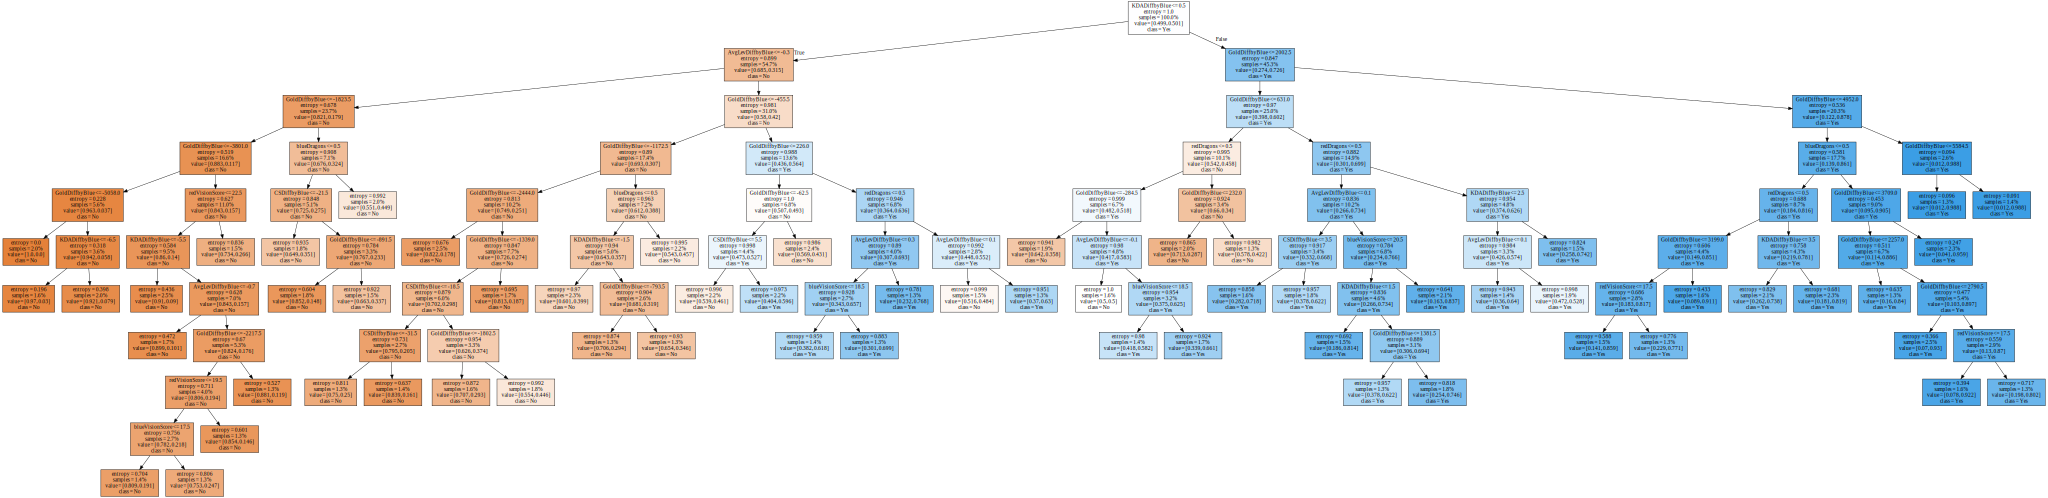

In [18]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(model_tr,
                           feature_names=X_train.columns,
                           class_names=['No', 'Yes'],
                           filled=True,
                           proportion=True)

display(graphviz.Source(dot_data))

In [19]:
# RandomForestClassifier를 사용하여 모델 학습

from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(random_state=10)

model_rf.fit(X_train, y_train)

y_val_pred = model_rf.predict(X_val)

print('RandomForestClassifier의 검증 정확도 : %.3f' % accuracy_score(y_val, y_val_pred))

RandomForestClassifier의 검증 정확도 : 0.708


In [20]:
dists = {
    'max_depth' : range(1, 100, 5),
    'n_estimators' : range(1, 100, 5),
    'max_features' : range(1, len(X_train.columns)+1)
}

clf_rf = RandomizedSearchCV(
    model_rf,
    param_distributions = dists,
    n_iter = 50,
    cv = 3,
    scoring = 'accuracy',
    verbose = 1,
    n_jobs = -1,
    random_state=10
)

clf_rf.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   47.3s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [21]:
print('최적 하이퍼파라미터 :', clf_rf.best_params_)
print('Accuracy : %.3f' % clf_rf.best_score_)

model_rf = clf_rf.best_estimator_

y_val_pred = model_rf.predict(X_val)

print('\nRandomForestClassifier의 검증 정확도 : %.3f' % accuracy_score(y_val, y_val_pred))

최적 하이퍼파라미터 : {'n_estimators': 46, 'max_features': 8, 'max_depth': 6}
Accuracy : 0.734

RandomForestClassifier의 검증 정확도 : 0.725


In [22]:
y_pred_proba = model_rf.predict_proba(X_val)[:,1]

fpr, tpr, thres = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thres
})

optimal_idx = np.argmax(tpr - fpr)
optimal_thres = thres[optimal_idx]

print('idx:', optimal_idx, ', threshold:', round(optimal_thres,3))

auc_score = roc_auc_score(y_val, y_pred_proba)
print('AUC Score :', round(auc_score, 3))

y_pred = [None] * len(y_pred_proba)

for idx in range(len(y_pred_proba)):
  if y_pred_proba[idx] >= optimal_thres:
    y_pred[idx] = 1
  else:
    y_pred[idx] = 0

# 최적의 threshold = 0.473 를 사용하여 y_pred 조정.

print('\nRandomForestClassifier의 검증 정확도 : %.3f' % accuracy_score(y_val, y_pred))

idx: 310 , threshold: 0.473
AUC Score : 0.807

RandomForestClassifier의 검증 정확도 : 0.729


In [23]:
# XGBoostClassifier를 사용하여 모델 학습

from xgboost import XGBClassifier

model_gb = XGBClassifier(n_estimators=1000, max_depth = 7, max_features = 13, learning_rate = 0.01, random_state = 10)

eval_set = [(X_train, y_train), (X_val, y_val)]

model_gb.fit(X_train, y_train,
             eval_set = eval_set,
             eval_metric='error',
             early_stopping_rounds=30)

y_val_pred = model_gb.predict(X_val)

print('\nXClassifier의 검증 정확도 : %.3f' % accuracy_score(y_val, y_val_pred))

[0]	validation_0-error:0.24217	validation_1-error:0.282732
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.242012	validation_1-error:0.283365
[2]	validation_0-error:0.242012	validation_1-error:0.283365
[3]	validation_0-error:0.242328	validation_1-error:0.283365
[4]	validation_0-error:0.239639	validation_1-error:0.282732
[5]	validation_0-error:0.240272	validation_1-error:0.278305
[6]	validation_0-error:0.239956	validation_1-error:0.278937
[7]	validation_0-error:0.241221	validation_1-error:0.280202
[8]	validation_0-error:0.240905	validation_1-error:0.280835
[9]	validation_0-error:0.239323	validation_1-error:0.280835
[10]	validation_0-error:0.239165	validation_1-error:0.280202
[11]	validation_0-error:0.238848	validation_1-error:0.278305
[12]	validation_0-error:0.239165	validation_1-error:0.278305
[13]	validation_0-error:0.23869	validation_1-error:0.2783

In [24]:
dists = {
    'n_estimators' : range(1, 100, 5),
    'max_depth' : range(1, 10),
    'max_features' : range(1, len(X_train.columns)+1),
    'learning_rate' : np.arange(0, 1, 0.01)
}

clf_gb = RandomizedSearchCV(
    model_gb,
    param_distributions = dists,
    n_iter = 20,
    cv = 3,
    scoring = 'accuracy',
    verbose = 1,
    n_jobs = -1,
    random_state=10
)

clf_gb.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   10.7s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.01, max_delta_step=0,
                                           max_depth=7, max_features=13,
                                           min_child_weight=1, missing=None,
                                           n_estimators=1000, n_jobs=1,
                                           nthread=None,
                                           objective='binary:logistic',
                                           random_state=10, reg_alph...
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0

In [25]:
print('최적 하이퍼파라미터 :', clf_gb.best_params_)
print('Accuracy : %.3f' % clf_gb.best_score_)

model_gb = clf_gb.best_estimator_

y_val_pred = model_gb.predict(X_val)

print('\nRandomForestClassifier의 검증 정확도 : %.3f' % accuracy_score(y_val, y_val_pred))

최적 하이퍼파라미터 : {'n_estimators': 86, 'max_features': 8, 'max_depth': 1, 'learning_rate': 0.16}
Accuracy : 0.733

RandomForestClassifier의 검증 정확도 : 0.732


In [26]:
y_pred_proba = model_gb.predict_proba(X_val)[:,1]

fpr, tpr, thres = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thres
})

optimal_idx = np.argmax(tpr - fpr)
optimal_thres = thres[optimal_idx]

print('idx:', optimal_idx, ', threshold:', round(optimal_thres,3))

auc_score = roc_auc_score(y_val, y_pred_proba)
print('AUC Score :', round(auc_score, 3))

y_pred = [None] * len(y_pred_proba)

for idx in range(len(y_pred_proba)):
  if y_pred_proba[idx] >= optimal_thres:
    y_pred[idx] = 1
  else:
    y_pred[idx] = 0

# 최적의 threshold = 0.497 를 사용하여 y_pred 조정.

print('\nXGBoostClassifier의 검증 정확도 : %.3f' % accuracy_score(y_val, y_pred))

idx: 242 , threshold: 0.497
AUC Score : 0.807

XGBoostClassifier의 검증 정확도 : 0.734


In [27]:
pip install eli5

In [28]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model_tr,
    scoring = 'accuracy',
    n_iter = 5,
    random_state = 10
)

permuter.fit(X_train, y_train)

eli5.show_weights(
    permuter,
    top=None,
    feature_names = X_train.columns.tolist()
)

Weight,Feature
0.1413 ± 0.0079,GoldDiffbyBlue
0.0098 ± 0.0028,KDADiffbyBlue
0.0078 ± 0.0039,AvgLevDiffbyBlue
0.0078 ± 0.0020,redDragons
0.0024 ± 0.0018,CSDiffbyBlue
0 ± 0.0000,redVisionScore
0 ± 0.0000,blueVisionScore
0 ± 0.0000,redTowersDestroyed
0 ± 0.0000,redHeralds
0 ± 0.0000,blueTowersDestroyed


In [29]:
minimum_importance = 0.001
mask = permuter.feature_importances_ >= minimum_importance
features = X_train.columns[mask]
X_train_selected = X_train[features]
X_val_selected = X_val[features]
X_test_selected = X_test[features]

In [30]:
features

Index(['redDragons', 'KDADiffbyBlue', 'CSDiffbyBlue', 'GoldDiffbyBlue',
       'AvgLevDiffbyBlue'],
      dtype='object')

In [31]:
# 사용하지 않을 특성 제거 후 DecisionTreeClassifier를 사용하여 모델 학습

model_tr = DecisionTreeClassifier(random_state=10)

model_tr.fit(X_train_selected, y_train)

y_val_pred = model_tr.predict(X_val_selected)

print('DecisionTreeClassifier의 검증 정확도 : %.3f' % accuracy_score(y_val, y_val_pred))

DecisionTreeClassifier의 검증 정확도 : 0.619


In [32]:
dists = {
    'max_depth' : range(1, 100, 5),
    'criterion' : ['gini', 'entropy'],
    'min_samples_leaf' : range(1, 100, 5),
    'max_features' : range(1, len(X_train_selected.columns)+1)
}

clf_tr = RandomizedSearchCV(
    model_tr,
    param_distributions = dists,
    n_iter = 50,
    cv = 3,
    scoring = 'accuracy',
    verbose = 1,
    n_jobs = -1,
    random_state=10
)

clf_tr.fit(X_train_selected, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.4s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=10,
            

In [33]:
print('최적 하이퍼파라미터 :', clf_tr.best_params_)
print('Accuracy : %.3f' % clf_tr.best_score_)

model_tr = clf_tr.best_estimator_

y_val_pred = model_tr.predict(X_val_selected)

print('\nDecisionTreeClassifier의 검증 정확도 : %.3f' % accuracy_score(y_val, y_val_pred))

최적 하이퍼파라미터 : {'min_samples_leaf': 91, 'max_features': 3, 'max_depth': 91, 'criterion': 'gini'}
Accuracy : 0.731

DecisionTreeClassifier의 검증 정확도 : 0.731


In [34]:
y_pred_proba = model_tr.predict_proba(X_val_selected)[:,1]

fpr, tpr, thres = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thres
})

optimal_idx = np.argmax(tpr - fpr)
optimal_thres = thres[optimal_idx]

print('idx:', optimal_idx, ', threshold:', optimal_thres)

auc_score = roc_auc_score(y_val, y_pred_proba)
print('AUC Score :', round(auc_score, 3))

y_pred = [None] * len(y_pred_proba)

for idx in range(len(y_pred_proba)):
  if y_pred_proba[idx] >= optimal_thres:
    y_pred[idx] = 1
  else:
    y_pred[idx] = 0

# 최적의 threshold = 0.457 를 사용하여 y_pred 조정.

print('\nDecisionTreeClassifier의 검증 정확도 : %.3f' % accuracy_score(y_val, y_pred))

idx: 25 , threshold: 0.5643564356435643
AUC Score : 0.797

DecisionTreeClassifier의 검증 정확도 : 0.734


In [35]:
# DecisionTreeClassifier를 사용하여 시험

y_pred_proba = model_tr.predict_proba(X_test_selected)[:,1]

y_pred = [None] * len(y_pred_proba)

for idx in range(len(y_pred_proba)):
  if y_pred_proba[idx] >= optimal_thres:
    y_pred[idx] = 1
  else:
    y_pred[idx] = 0

# 최적의 threshold = 0.497 를 사용하여 y_pred 조정.

print('DecisionTreeClassifier의 시험 정확도 : %.3f' % accuracy_score(y_test, y_pred))

DecisionTreeClassifier의 시험 정확도 : 0.706


In [36]:
pip install shap

In [37]:
pip install pdpbox

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


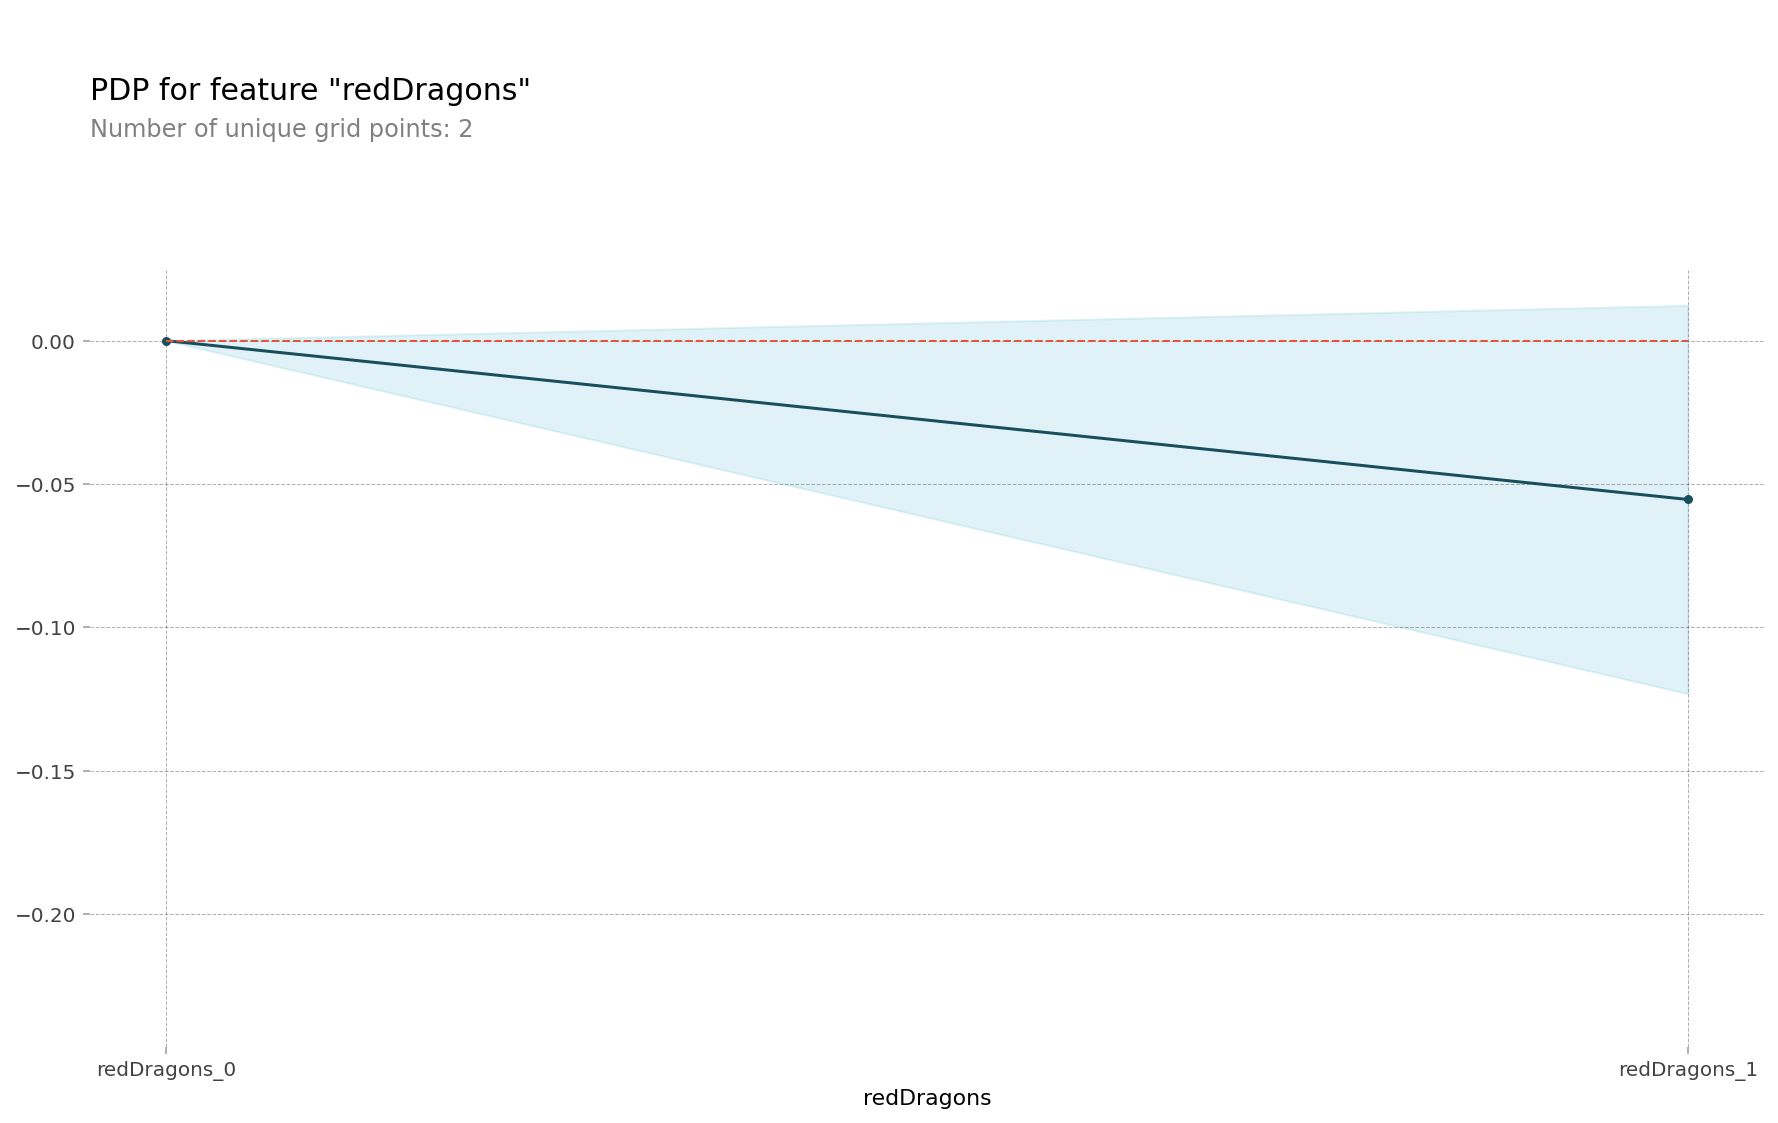

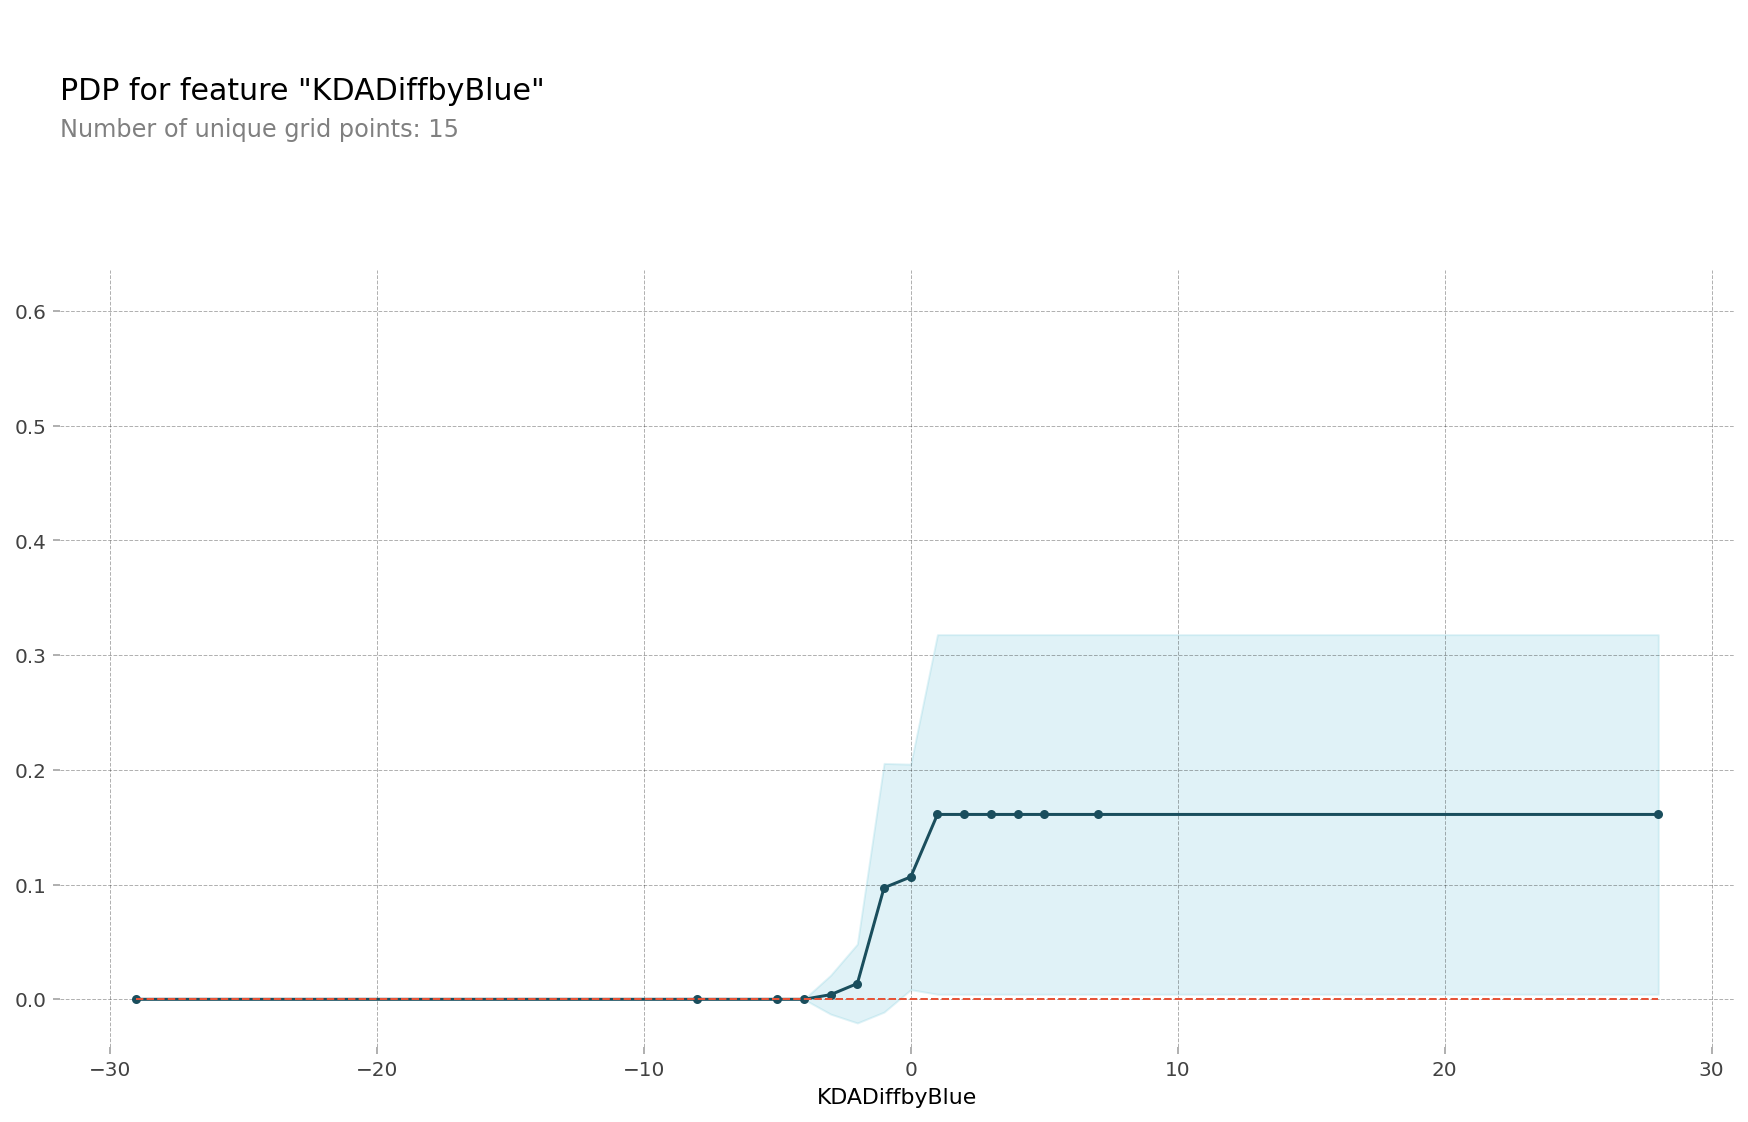

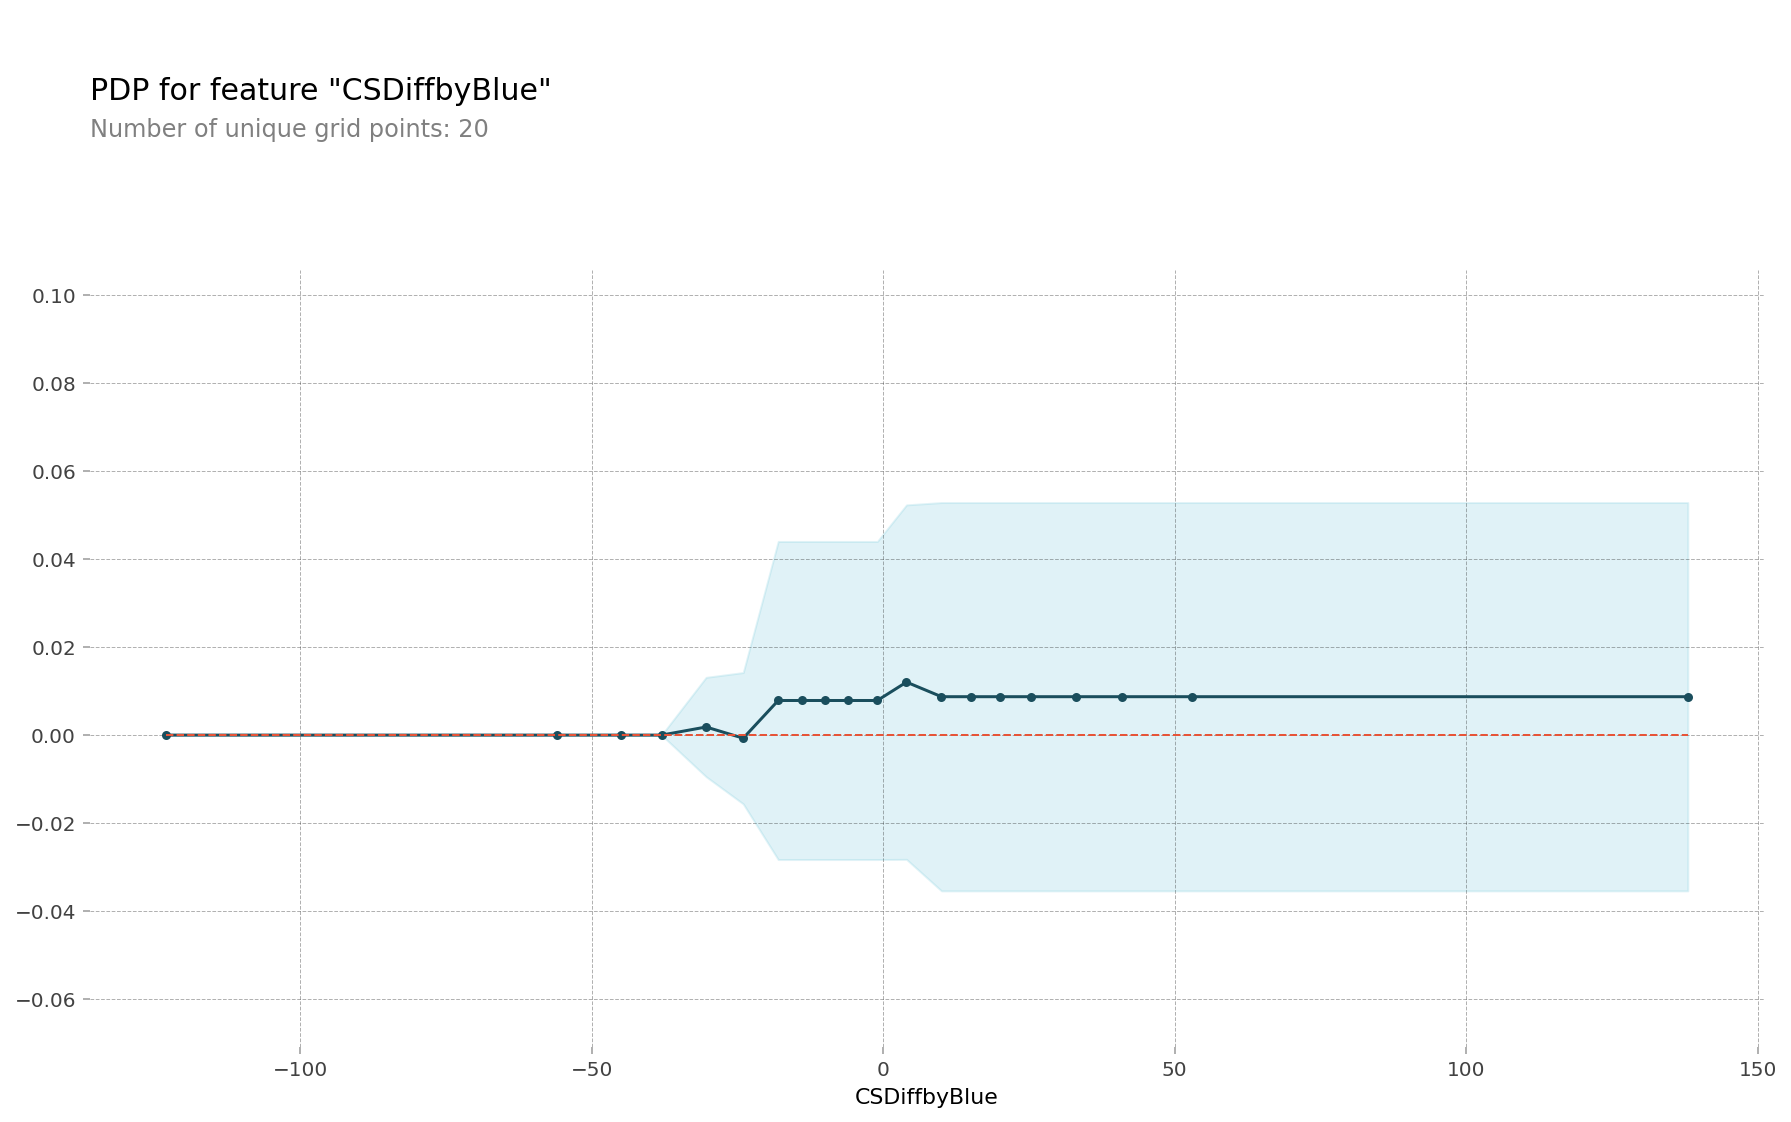

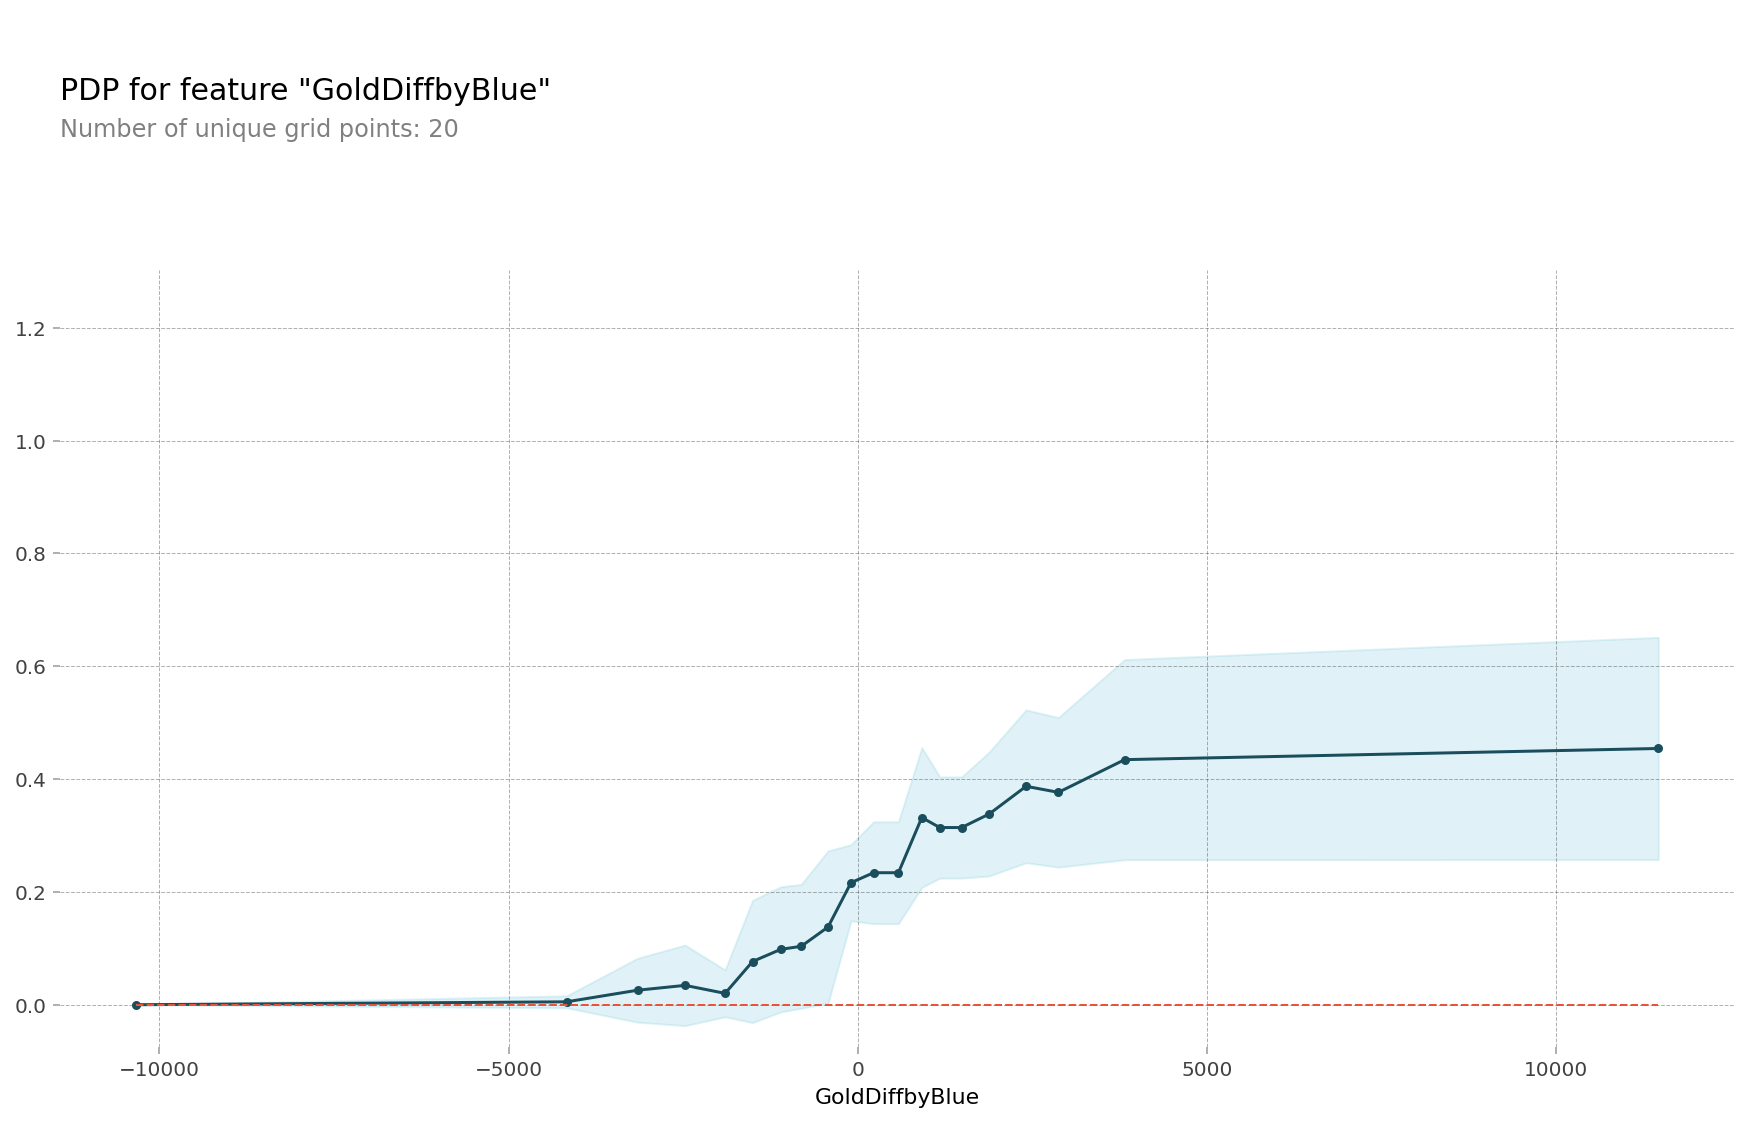

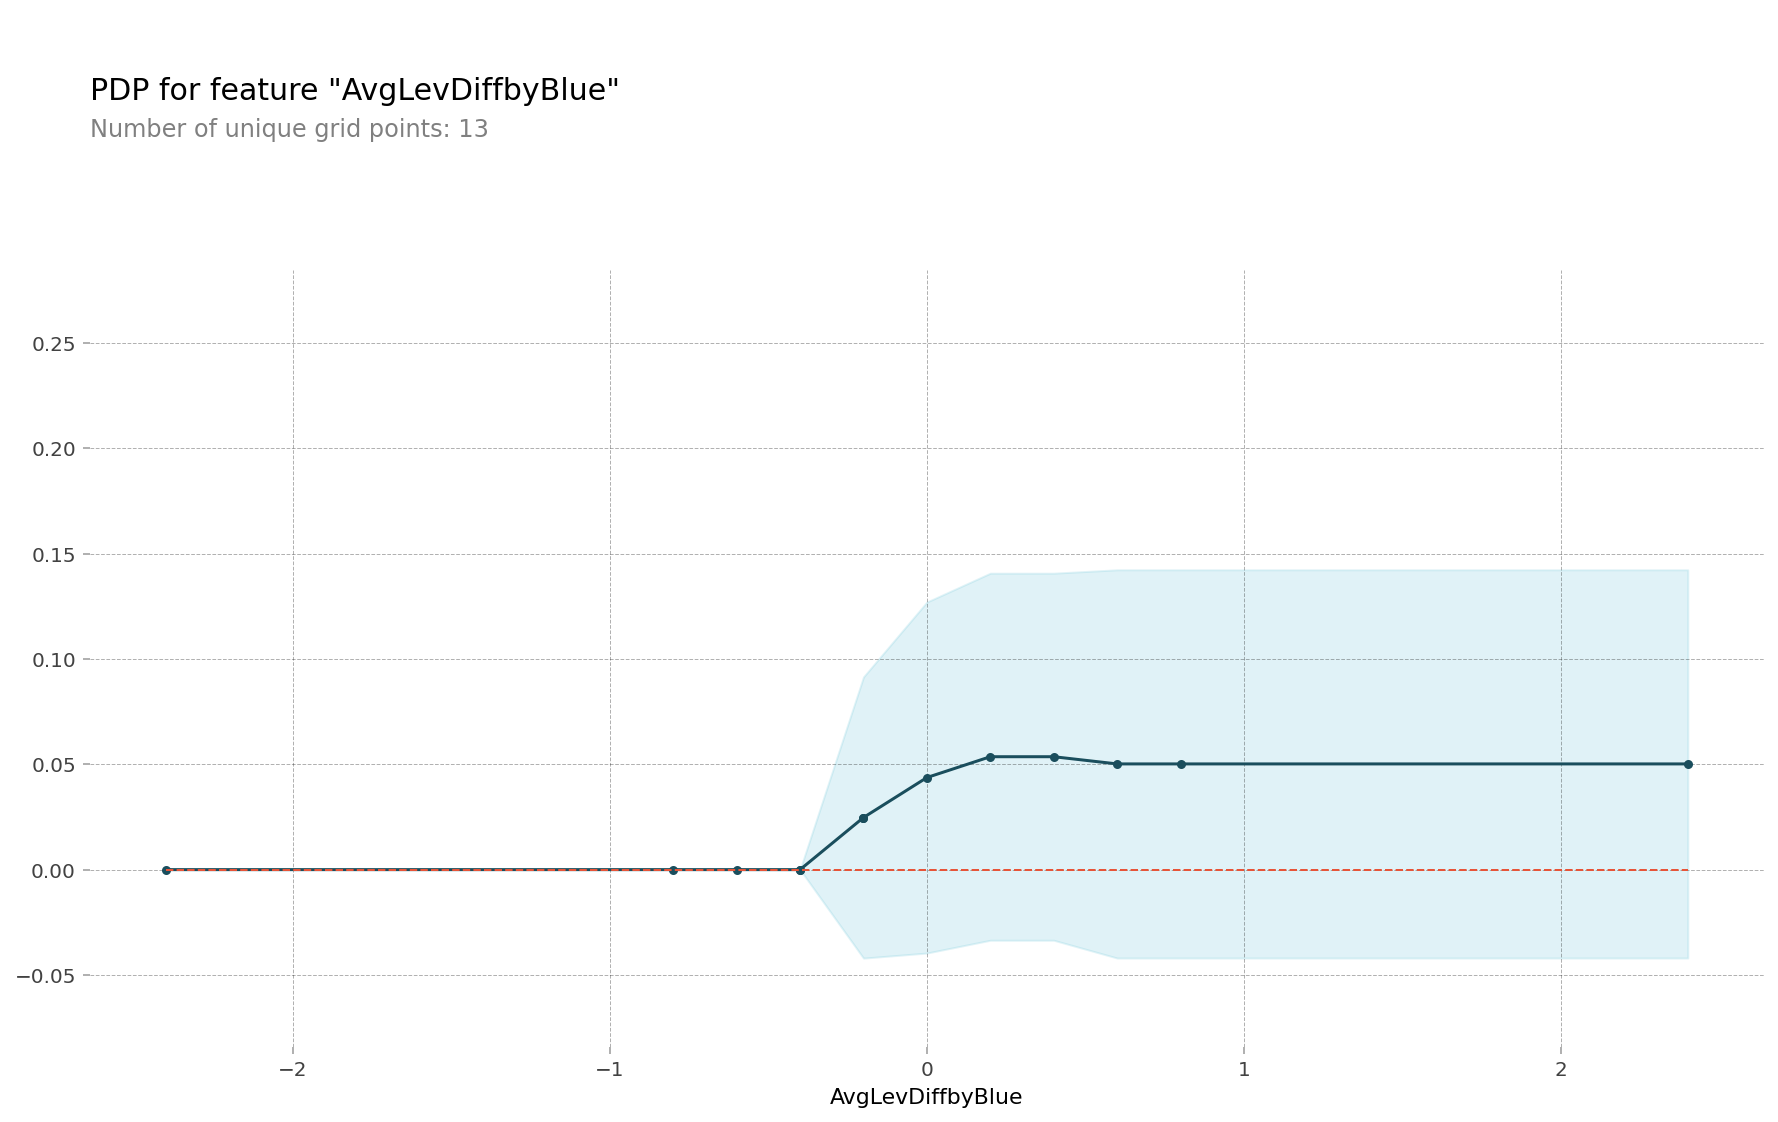

In [38]:
from pdpbox.pdp import pdp_isolate, pdp_plot

def plot_pdp(model, dataset, features):

  for feature in features:
    isolation = pdp_isolate(
      model = model,
      dataset = dataset,
      model_features = dataset.columns,
      feature = feature,
      grid_type = 'percentile',
      num_grid_points = 20
    )

    pdp_plot(isolation, feature_name=feature)

plot_pdp(model_tr, X_val_selected, X_val_selected.columns.tolist())

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


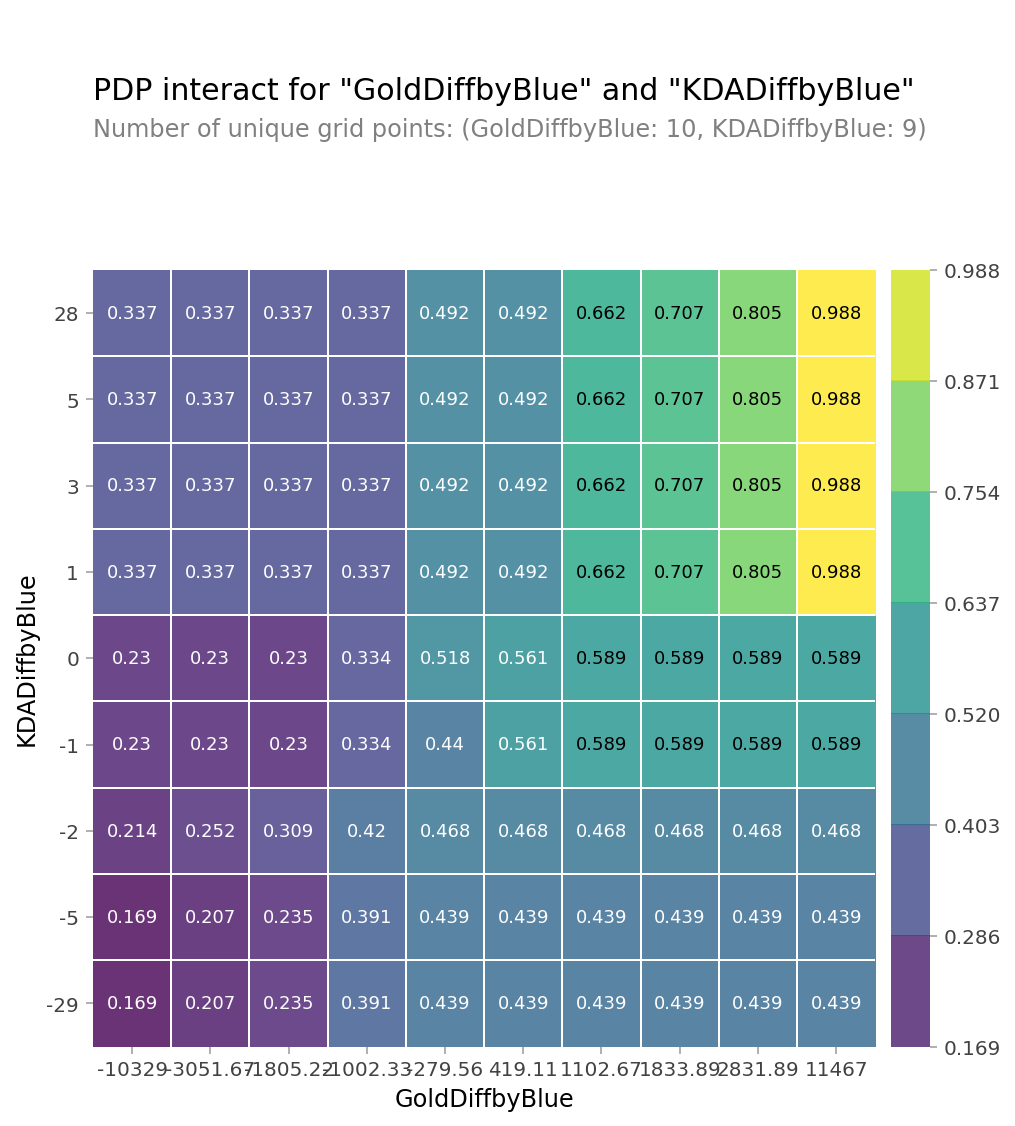

In [39]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['GoldDiffbyBlue', 'KDADiffbyBlue']

interaction = pdp_interact(
    model = model_tr,
    dataset = X_val_selected,
    model_features = X_val_selected.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [68]:
import shap

row = X_val_selected.iloc[[185]]
explainer = shap.TreeExplainer(model_tr)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value = explainer.expected_value[0],
    shap_values = shap_values[1],
    features = row
)

In [69]:
model_tr.predict(row)

array([1])

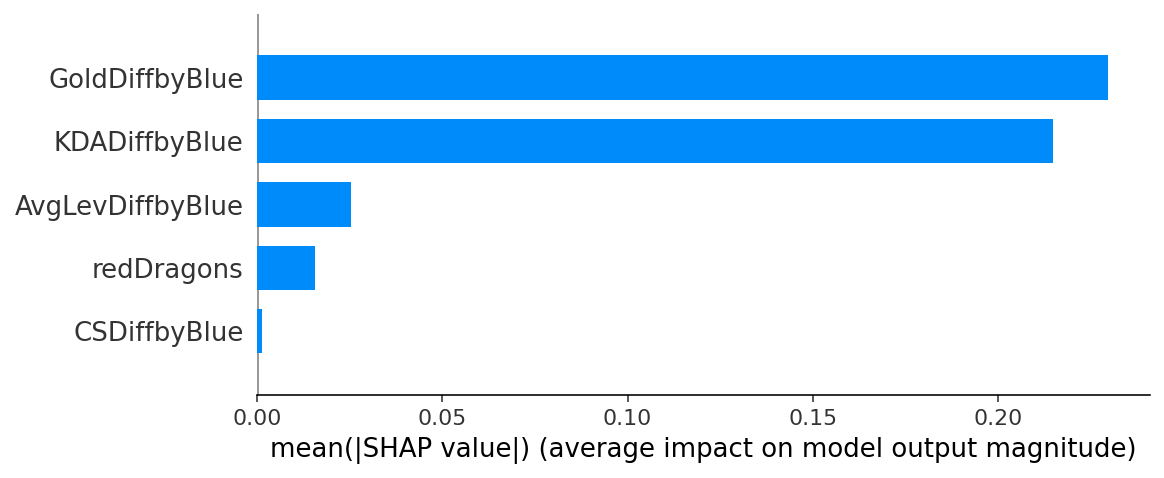

In [70]:
shap.summary_plot(shap_values[1], X_val_selected, plot_type='bar')